In [41]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from keras.models import Model
from keras.layers import Input, Conv1D, GlobalAveragePooling1D, Dense, Dropout, Multiply, Permute, Reshape, Lambda
from keras import backend as K

In [50]:
def attention_layer(inputs, input_dim, time_steps):
    # inputs.shape = (batch_size, time_steps_after_conv, input_dim)
    a = Permute((2, 1))(inputs)  # (batch_size, input_dim, time_steps_after_conv)
    a = Dense(time_steps, activation='sigmoid')(a)  # (batch_size, time_steps_after_conv, input_dim)
    a_probs = Permute((2, 1), name='attention_vec')(a)  # (batch_size, input_dim, time_steps_after_conv)
    output_attention_mul = Multiply()([inputs, a_probs])
    return output_attention_mul

In [51]:
# Load the dataset
train1 = pd.read_csv('/home/disi/ff/Datasets/Dataset_2/Train1.csv')
train2 = pd.read_csv('/home/disi/ff/Datasets/Dataset_2/Train2.csv')
test = pd.read_csv('/home/disi/ff/Datasets/Dataset_2/Test.csv')

In [52]:
# Combine training data
train_data = pd.concat([train1, train2])

In [53]:
# Select relevant features
features = ['Temperature', 'Humidity', 'Light']  # Update these names based on actual column names in your CSV
train_data = pd.concat([train1, train2])[features]
X_train = train_data
y_train = train_data  # if predicting the same features
X_test = test[features]
y_test = test[features]

In [54]:
# Data normalization
scaler = MinMaxScaler(feature_range=(0, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)
y_train_scaled = scaler.transform(y_train)
y_test_scaled = scaler.transform(y_test)

In [55]:
# Create sequences
time_steps = 5  # Number of time steps
X_train_seq, y_train_seq = create_sequences(X_train_scaled, y_train_scaled, time_steps)
X_test_seq, y_test_seq = create_sequences(X_test_scaled, y_test_scaled, time_steps)



In [57]:
# Model building
inputs = Input(shape=(time_steps, input_dim))
conv = Conv1D(filters=64, kernel_size=2, activation='relu', padding='same')(inputs)
# Adjust the number of time steps after the convolution
time_steps_after_conv = conv.shape[1]
attention = attention_layer(conv, 64, time_steps_after_conv)
gap_layer = GlobalAveragePooling1D()(attention)
dense = Dense(50, activation='relu')(gap_layer)
dropout = Dropout(0.2)(dense)
output = Dense(input_dim)(dropout)  # Number of features to predict

model = Model(inputs=[inputs], outputs=output)
model.compile(optimizer='adam', loss='mse')


In [58]:
# Train the model
model.fit(X_train_seq, y_train_seq, epochs=20, batch_size=32, validation_split=0.2)


Epoch 1/20


271/271 [==============================] - 2s 3ms/step - loss: 0.0163 - val_loss: 7.2559e-04
Epoch 2/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0039 - val_loss: 4.2215e-04
Epoch 3/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0031 - val_loss: 2.5302e-04
Epoch 4/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0028 - val_loss: 3.3465e-04
Epoch 5/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 5.6474e-04
Epoch 6/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0024 - val_loss: 2.5657e-04
Epoch 7/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0023 - val_loss: 3.4884e-04
Epoch 8/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 4.0348e-04
Epoch 9/20
271/271 [==============================] - 1s 2ms/step - loss: 0.0022 - val_loss: 5.4997e-04
Epoch 10/20
271/271 [==============================] - 1s 2ms/step - loss: 

In [59]:
# Evaluate the model
y_pred = model.predict(X_test_seq)
mse = mean_squared_error(y_test_seq, y_pred)
rmse = sqrt(mse)
mape = mean_absolute_percentage_error(y_test_seq, y_pred)

print('Test MSE: %.3f' % mse)
print('Test RMSE: %.3f' % rmse)
print('Test MAPE: %.3f' % mape)

 77/305 [======>.......................] - ETA: 0s

305/305 [==============================] - 0s 1ms/step
Test MSE: 0.000
Test RMSE: 0.015
Test MAPE: 7032094510753.683


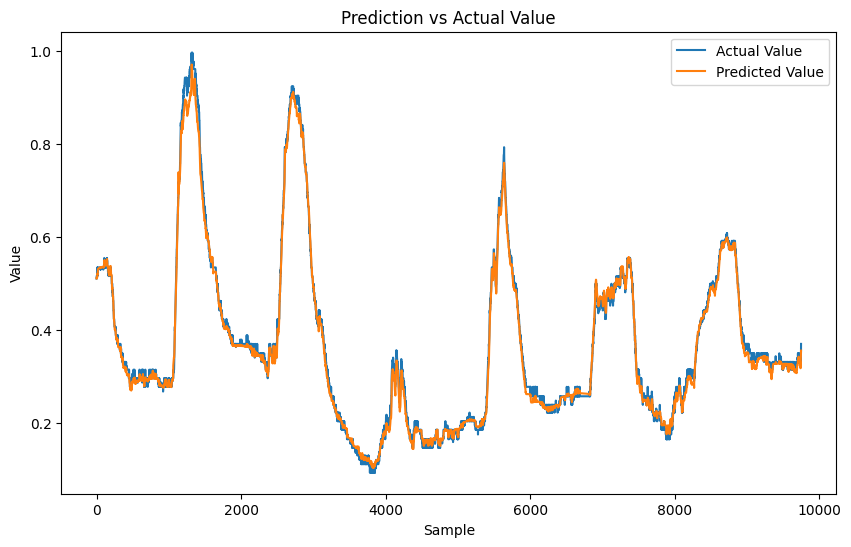

In [60]:
# Plotting predicted vs actual values
plt.figure(figsize=(10, 6))
plt.plot(y_test_seq[:, 0], label='Actual Value')
plt.plot(y_pred[:, 0], label='Predicted Value')
plt.title('Prediction vs Actual Value')
plt.xlabel('Sample')
plt.ylabel('Value')
plt.legend()
plt.show()